In [118]:
import tweepy
import textblob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import yaml
import nltk


from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud 
import string

from notebookjs import execute_js
d3 = "https://d3js.org/d3.v3.min.js"

with open("visualization/template/style.css", "r") as f:
    style = f.read()
    
with open ("./visualization/template/script.js", "r") as f:
    script = f.read()

keys=yaml.safe_load(open('twitterkeys.yaml'))

In [22]:
config_OAuth=[
    keys['API_key'],
    keys['API_key_secret']
]

config_AccessToken=[
    keys['access_token'],
    keys['access_token_secret']
]

In [253]:
authenticator = tweepy.OAuthHandler(*config_OAuth)
authenticator.set_access_token(*config_AccessToken)

api =tweepy.API(authenticator, wait_on_rate_limit=True)

topic = 'germany'

search = f'#{topic} -filter:retweets'

tweet_cursor = tweepy.Cursor(api.search_tweets, q=search, lang='en', tweet_mode='extended').items(1000)


tweets=[[tweet.created_at.date(),tweet.full_text] for tweet in tweet_cursor]

tweets_df = pd.DataFrame(tweets, columns=['date','Tweets'])


In [254]:
tweets_df

,date,Tweets
0,2022-11-02,"Biogen is hiring a (Sr) Associate, Medical Aff..."
1,2022-11-02,Today's #wine is a Spätlese Riesling Prädikats...
2,2022-11-02,The Russians fell into a trap near Kherson / U...
3,2022-11-02,#NEW:#PAULMCCARTNEY LEGACY:VOL1:1969–73 (2022)...
4,2022-11-02,All-out Attack!! Ukrainian forces destroying R...
...,...,...
995,2022-11-02,👀✈️🔊\nD-AIGO \n#DLH7K \n#Lufthansa \n#Germany\...
996,2022-11-02,Ukrainians used as 'bargaining chips' in Russi...
997,2022-11-02,Fighting rages in east of Ukraine- BBC News\n#...
998,2022-11-02,Mariupol “on brink of capture” as Russia claim...


In [255]:
for _, row in tweets_df.iterrows():
    row['Tweets'] = re.sub('http\S+', '', row['Tweets'])
    row['Tweets'] = re.sub('#\S+', '', row['Tweets'])
    row['Tweets'] = re.sub('@\S+', '', row['Tweets'])
    row['Tweets'] = re.sub('\\n', '', row['Tweets'])

In [256]:
tweets_df.head(10)

,date,Tweets
0,2022-11-02,"Biogen is hiring a (Sr) Associate, Medical Aff..."
1,2022-11-02,Today's is a Spätlese Riesling Prädikatswein ...
2,2022-11-02,The Russians fell into a trap near Kherson / U...
3,2022-11-02,LEGACY:VOL1:1969–73 (2022)by Allan Kozinn&amp...
4,2022-11-02,All-out Attack!! Ukrainian forces destroying R...
5,2022-11-02,I moved away from about a month ago. Literall...
6,2022-11-02,DAY 251 Ukraine Russia War Map Kherson Offensi...
7,2022-11-02,GoPro footage!! Ukrainian troops attacking ene...
8,2022-11-02,Kherson is lost? The Russian army is fleeing t...
9,2022-11-02,Russia retaliates against Ukraine drone attack...


In [257]:
tweets_df['Polarity']=tweets_df['Tweets'].map(lambda tweet: textblob.TextBlob(tweet).sentiment.polarity)


In [258]:
tweets_df.describe()

,Polarity
count,1000.000000
mean,0.024398
std,0.243336
min,-1.000000
25%,-0.050000
50%,0.000000
75%,0.064786
max,1.000000


In [259]:
tweets_df['Polarity_Ranking']=tweets_df['Polarity'].map(lambda pol: '+' if pol>0.2 else ('-' if pol<-0.2 else  'Neutral'))


In [260]:
tweets_df.head(10)

,date,Tweets,Polarity,Polarity_Ranking
0,2022-11-02,"Biogen is hiring a (Sr) Associate, Medical Aff...",0.000000,Neutral
1,2022-11-02,Today's is a Spätlese Riesling Prädikatswein ...,0.250000,+
2,2022-11-02,The Russians fell into a trap near Kherson / U...,0.100000,Neutral
3,2022-11-02,LEGACY:VOL1:1969–73 (2022)by Allan Kozinn&amp...,0.000000,Neutral
4,2022-11-02,All-out Attack!! Ukrainian forces destroying R...,-0.243750,-
5,2022-11-02,I moved away from about a month ago. Literall...,-0.387500,-
6,2022-11-02,DAY 251 Ukraine Russia War Map Kherson Offensi...,0.000000,Neutral
7,2022-11-02,GoPro footage!! Ukrainian troops attacking ene...,0.000000,Neutral
8,2022-11-02,Kherson is lost? The Russian army is fleeing t...,0.000000,Neutral
9,2022-11-02,Russia retaliates against Ukraine drone attack...,-0.166667,Neutral


In [261]:
positive=tweets_df[tweets_df['Polarity_Ranking'] == '+'].shape[0]
negative=tweets_df[tweets_df['Polarity_Ranking'] == '-'].shape[0]
neutral=tweets_df[tweets_df['Polarity_Ranking'] == 'Neutral'].shape[0]

In [262]:
positive

149

In [263]:
negative

117

In [264]:
neutral

734

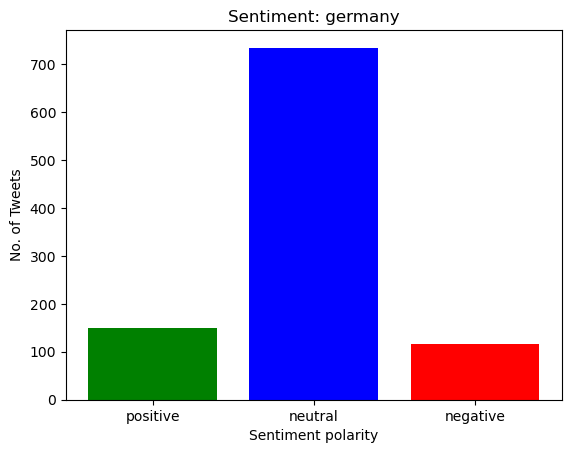

In [265]:
plt.bar(['positive', 'neutral', 'negative'], [positive, neutral, negative],  color= ['green','blue','red'])
plt.title(f'Sentiment: {topic}')
plt.xlabel("Sentiment polarity")
plt.ylabel("No. of Tweets")

plt.show()

In [266]:
text = ' '.join([word for word in tweets_df['Tweets']])

In [267]:
def CleanCount(text):
    nltk_tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    nltk_tokens= [word.lower() for word in nltk_tokens if word.isalpha()]
 
    filtered_words = []

    for w in nltk_tokens:
        if w not in stop_words:
            filtered_words.append(w) 
    
    word_frq = nltk.FreqDist(filtered_words)
 
    df = pd.DataFrame.from_dict(word_frq, orient='index')
    df.columns = ['value']
    df.index.name = 'name'
    df.reset_index(inplace=True)

    return filtered_words, word_frq, df

In [268]:
words,counts,df  = CleanCount(text)

In [269]:
execute_js(library_list=[d3, script], main_function="radial_bar", data_dict=df.sort_values(ascending=False, by=["value"])[:15].to_dict(orient="records"), css_list=[style])

In [270]:
all_words_lem = ' '.join([word for word in words])

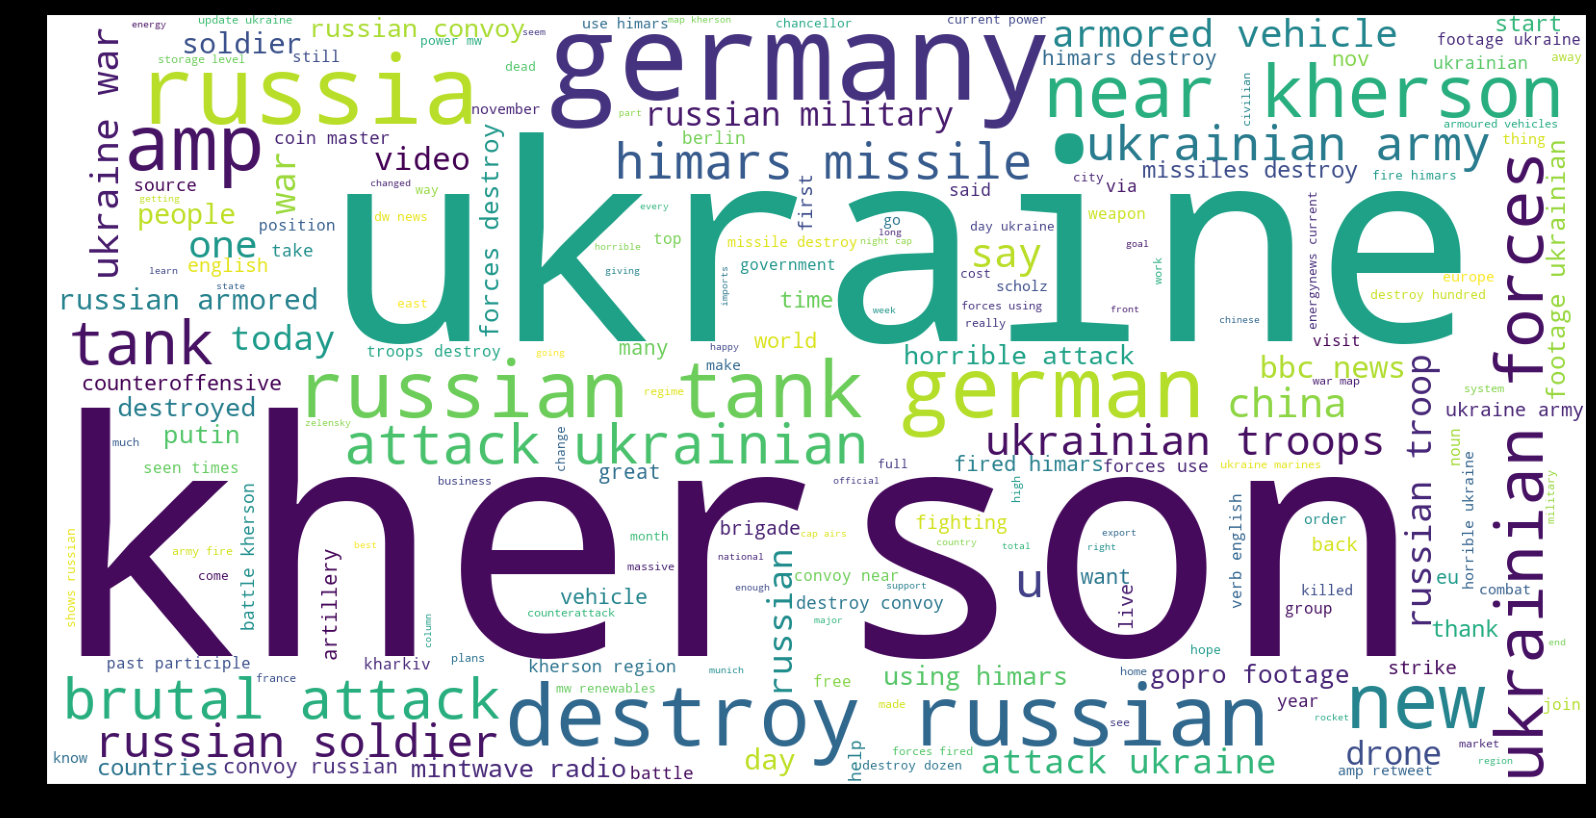

In [271]:
wordcloud = WordCloud(background_color="white",width=1600, height=800,relative_scaling=1).generate(all_words_lem)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

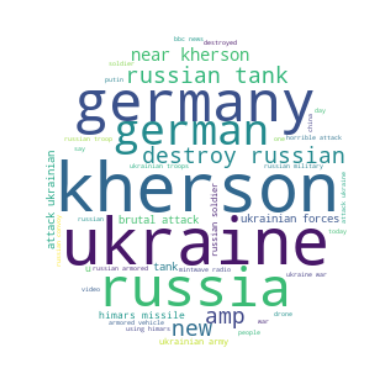

In [272]:
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(all_words_lem)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")